# Data Augmentation

In this notebook, we will see step by step how we can augment the number of data we have. We will use handwritten images.

These images are stored in the `data` folder and have been obtained by running the `draw_digit.py` script.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

## Example of images 

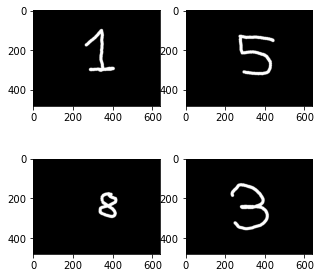

In [2]:
DATA_PATH = 'data/'

#Visualisation
fig, axs = plt.subplots(2,2, figsize=(5,5))
axs[0,0].imshow(cv2.imread(DATA_PATH+'1_0.jpg'))
axs[0,1].imshow(cv2.imread(DATA_PATH+'5_4.jpg'))
axs[1,0].imshow(cv2.imread(DATA_PATH+'8_2.jpg'))
axs[1,1].imshow(cv2.imread(DATA_PATH+'3_4.jpg'))

Images are black and white, let's check the shape of the images

shape :  (480, 640, 3)


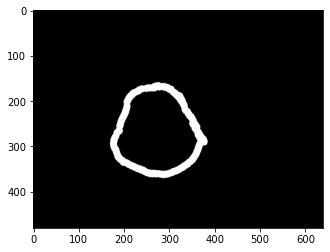

In [3]:
img = cv2.imread('data/0_0.jpg') #every images have the same shape
print('shape : ', img.shape)
plt.imshow(img)

We see that actually these images are RGB images. But since images are black and white, we can load these images on one channel (gray scale) without removing any useful information. Having images in gray-scale allows to greatly reduce the computational complexity since there is less channels.

(480, 640)


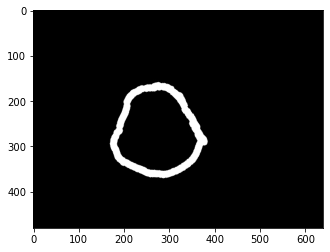

In [4]:
#loading the image in gray-scale
img = cv2.imread('data/0_0.jpg', 0) #we add "0" to load the image in gray-scale (default is 1=color)
plt.imshow(img, cmap="gray", vmin=0, vmax=255) #we have to specify to plt that the image is in gray-scale
print(img.shape)

In the following, we will load the digits in gray-scale

## Location of the image, rotation and scaling

We drew only 5 images per digit, this is clearly not enough to be totally robust to parameters such as the different ways to draw a digit, the possible "errors" and bad writing. But also the place where the digit is : if all ones are located at top left, and other digits are located somewhere else, then the classifier will surely learn that all symbols located at top left are ones.

But drawing hundreds of digit is a bit tiring, so we will need to make the classifier robust by performing data augmentation. A possible flaw we can control is the location of the digit : we can zoom on the digit to be insensitive to the location of the digit :

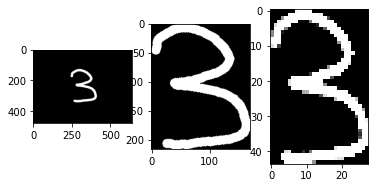

In [6]:
img = cv2.imread('data/3_1.jpg', 0)
rows, cols = np.where(img==255) #we get rows and cols 
img_centered = img[min(rows):max(rows), min(cols):max(cols)]

#we also need to reshape the image for the classification model later on 
img_res = cv2.resize(img_centered, (28, 44))

fig, axs = plt.subplots(1,3)
axs[0].imshow(img, cmap='gray', vmin=0, vmax=255)
axs[1].imshow(img_centered, cmap='gray', vmin=0, vmax=255)
axs[2].imshow(img_res, cmap='gray', vmin=0, vmax=255)

Being insensitive to the location of the digit is a good thing, now we need to be a bit less sensitive to the writing. Indeed, I only drew 5 times per digit, and one doesn't draw the same way all the time : the digit may be bigger, not have the same shape...

We will increase the number of data by rotating the digit from different values. We will use almost the same algorithm as in the `generate_digits.py` in the `classifier_fonts` folder.

## Data Augmentation

In [14]:
#we create a new folder that will contain these images
if not os.path.exists('data_augmented'):
    os.makedirs('data_augmented')


rotations = [0, 2,4,6,8,10,-2,-4,-6,-8,-10]
    
for i in range(10): #digit from 0 to 9
    count=0 #we intialize a counter for the number of images we treat
    for j in range(5): #number of the digit:
        img = cv2.imread('data/'+str(i)+'_'+str(j)+'.jpg', 0) #read the handwritten image
        for rotation in rotations:
            #rotate the image
            rows,cols = img.shape
            M = cv2.getRotationMatrix2D((cols/2,rows/2),rotation,1)
            rot = cv2.warpAffine(img,M,(cols,rows))
            
            #center the digit and resize it
            rows, cols = np.where(rot==255)
            img_centered = rot[min(rows):max(rows), min(cols):max(cols)]
            img_centered = cv2.resize(img_centered, (28, 44))
        
        
            #save the image in the folder
            #file path (we use the format '0_3' for the 3rd image of the digit 0)
            file_path = 'data_augmented/'+str(i)+'_'+str(count)+'.jpg'
            cv2.imwrite(file_path, img_centered)
            count+=1
        nb_images = count #we save the number of images for each digit

## Classification

In [18]:
#import libraries
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from sklearn.metrics import accuracy_score

**Prepare the data**

In [16]:
def prepare_data():
    x=[]
    y=[]
    
    for i in range(10):
        for j in range(nb_images):
            img = cv2.imread('data_augmented/'+str(i)+'_'+str(j)+'.jpg', 0)
            img = img/255.0 #normalizing the pixel values
            img = img.astype('float32') #converting the type of pixel to float 32
            
            x.append(img)
            y.append(i)
            
    x = np.array(x)
    y = np.array(y)
    
    return x,y

X, y = prepare_data()

print('Shape of X : {}'.format(X.shape))
print('Shape of y : {}'.format(y.shape))

Shape of X : (550, 44, 28)
Shape of y : (550,)


**Define the model**

In [28]:
class img_class(nn.Module):
    '''  Class implenting the network that will classify the images    '''
    
    def __init__(self):
        super(img_class, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3) #first convolution layer
        self.conv2 = nn.Conv2d(6, 16, 3) #second convolution layer
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 9 * 5, 120)  # 9*5 from image dimension after the 2 convolutions+pooling (divide by 4 and substract 2 for both dimensions)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(x.size(0), -1)
        x= F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def learn(self, x_train, y_train, loss_function, optimizer, num_epochs):
        ''' Training process '''
        #convert x_train to a torch tensor
        x_train = x_train.reshape(len(x_train), 1, 44, 28) #reshape the array for torch
        tensor_x  = torch.from_numpy(x_train) #create the tensor
        tensor_x.requires_grad_()
        
        #convert y_train to a torch tensor
        tensor_y = torch.from_numpy(y_train)
        tensor_y = tensor_y.long() #convert to float
        
        #training : for each element of the input tensor 'tensor_x', compare the output of the model and the real label
        for i in range(num_epochs):
            
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            self.zero_grad()

            # Step 2 - compute model predictions and loss
            output = self(tensor_x) #output of the model (shape : (1050, 10))
            #pred_label = torch.argmax(output, dim=1)
            #pred_label = pred_label.float()

            #loss
            loss = loss_function(output, tensor_y) 

            # Step 3 - do a backward pass and a gradient update step
            optimizer.zero_grad()  
            loss.backward()
            optimizer.step()

            #if i % 10 == 0: #print every 10 epochs
             #   print('Epoch : {}/{}, Loss : {}'.format(i + 1, num_epochs, loss.item()))
                
    def testing(self, x_test, y_test):
        '''Testing process'''
        #convert x_test into a tensor
        x_test = x_test.reshape(len(x_test), 1, 44, 28) #reshape the array for torch
        tensor_x  = torch.from_numpy(x_test) #create the tensor
        
        #convert y_test to a torch tensor
        tensor_y = torch.from_numpy(y_test)
        tensor_y = tensor_y.long() #convert to float
        
        output = self(tensor_x)
        softmax = torch.exp(output).cpu()
        prob = list(softmax.detach().numpy())
        predictions = np.argmax(prob, axis=1)

        # accuracy on testing set
        return accuracy_score(y_test, predictions)
        
    def learn2(self, x_train, y_train, x_test, y_test, loss_function, optimizer, num_epochs):
        ''' Training process, second version : to have the training and testing errors '''
        train_losses = []
        test_losses = []
        
        #convert x_train to a torch tensor
        x_train = x_train.reshape(len(x_train), 1, 44, 28) #reshape the array for torch
        tensor_x  = torch.from_numpy(x_train) #create the tensor
        tensor_x.requires_grad_()
        
        #convert y_train to a torch tensor
        tensor_y = torch.from_numpy(y_train)
        tensor_y = tensor_y.long() #convert to float
        
        #convert x_test into a tensor
        x_test = x_test.reshape(len(x_test), 1, 44, 28) #reshape the array for torch
        tensor_xtest  = torch.from_numpy(x_test) #create the tensor
        #convert y_test to a torch tensor
        tensor_ytest = torch.from_numpy(y_test)
        tensor_ytest = tensor_ytest.long() #convert to float
        
        #training : for each element of the input tensor 'tensor_x', compare the output of the model and the real label
        for i in range(num_epochs):
            
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            self.zero_grad()

            # Step 2 - compute model predictions and loss
            output_train = self(tensor_x) #output of the model (shape : (1050, 10))
            output_test  = self(tensor_xtest)
            pred_label = torch.argmax(output_train, dim=1)
            pred_label = pred_label.float() #should be a number

            #loss
            loss_train = loss_function(output_train, tensor_y) 
            loss_test = loss_function(output_test, tensor_ytest)
            train_losses.append(loss_train)
            test_losses.append(loss_test)

            # Step 3 - do a backward pass and a gradient update step
            optimizer.zero_grad()  
            loss_train.backward()
            optimizer.step()

            if i % 10 == 0: #print every 2 epochs
                print('Epoch : {}/{}, Loss : {}'.format(i + 1, num_epochs, loss_train.item()))
        return train_losses, test_losses

In [29]:
from sklearn.model_selection import StratifiedKFold #for cross validation

def cross_val(X,y, n_folds, num_epochs):
    '''Implement cross validation'''
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
    accuracies=[]
    fold_nb=0
    for train_index, test_index in skf.split(X,y):
        #print the fold
        fold_nb+=1
        print('fold {}/{}'.format(fold_nb, n_folds))
        #split train test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        #define the model, train and test
        model = img_class()
        #define loss function and optimizer
        loss_function = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
        model.learn(X_train, y_train, loss_function, optimizer, num_epochs)
        acc = model.testing(X_test, y_test)
        accuracies.append(acc)
        print('acuracy : {:.2f}'.format(acc))
    return accuracies

accuracies = cross_val(X, y, n_folds=10, num_epochs=30)
print('Accuracy is {:.2f} +/- {:.2f}'.format(np.mean(accuracies), np.std(accuracies)))

fold 1/10
acuracy : 1.00
fold 2/10
acuracy : 1.00
fold 3/10
acuracy : 1.00
fold 4/10
acuracy : 1.00
fold 5/10
acuracy : 0.98
fold 6/10
acuracy : 1.00
fold 7/10
acuracy : 1.00
fold 8/10
acuracy : 1.00
fold 9/10
acuracy : 1.00
fold 10/10
acuracy : 1.00
Accuracy is 1.00 +/- 0.01


Again the accuracy is too high, we may overfit, we need to test on the python program if the model can predict our digits. Since the behaviour is the same for all folds, we use all the data to train the model.

In [31]:
model = img_class()
num_epochs = 30
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
model.learn(X, y, loss_function, optimizer, num_epochs)
torch.save(model.state_dict(), 'model_handwritten') #save the model